<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/3.%20Frameworks%20Software/Practica3.3.%20Keras%3A%20un%20primer%20ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 3.2. CLASIFICACIÓN MULTICLASE Y USO DE GPU

En la práctica anterior vimos como trabajar de forma básica con tensores de PyTorch para entrenar un modelo lineal sobre el dataset MNIST. En esta práctica vamos a ver una forma sencilla de cargar datos pre-definidos y de crear modelos secuenciales (por capas) en PyTorch. Por último, veremos cómo hacer uso de un acelerador, como la GPU. Para ello, usaremos una serie de módulos y clases que son muy útiles para crear y entrenar redes neuronales en PyTorch: [torch.nn](https://pytorch.org/docs/stable/nn.html), [torch.optim](https://pytorch.org/docs/stable/optim.html), [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) y [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader). Iremos construyendo sobre estas partes, poco a poco, para ver qué hace cada una. Primero, carguemos `torch.nn`, `Dataset` y `DataLoader`.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## 1. Preparación de los datos

### 1.1. Descarga de los datos 

Volveremos a trabajar con [MNIST](http://yann.lecun.com/exdb/mnist/), pero esta vez con los datos ya pre-procesados dentro de PyTorch. Este entorno tiene varias extensiones para trabajar con problemas de *visión* [torchvision](https://docs.pytorch.org/vision/stable/index.html), *audio* [torchaudio](https://docs.pytorch.org/audio/stable/index.html) y *texto* [torchtext](https://docs.pytorch.org/text/stable/index.html), entre otros. En nuestro caso, vamos a cargar MNIST desde la colección de [datasets de torchvision](https://docs.pytorch.org/vision/stable/datasets.html).

Para poder cargar los datos que trae de ejemplo torchvision hay que seguir dos pasos:
 * primero, cargar la librería torchvision que porporciona las herramientas para trabajar con el dataset concreto (que suelen estar en el paquete `torchvision.datasets`, en este caso llamado `MNIST`); y,
 * segundo, ejecutar el proceso de carga de los datos para el conjunto de entrenamiento y para el de test. Como es la primera vez que realizamos este proceso concreto, debemos indicar que queremos descargar los datos, ya que, debido a su tamaño, no se instalan por defecto junto con la librería:

In [2]:
import torchvision

train_data = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_data = torchvision.datasets.MNIST("./data/", train=False, download=True)

# posiblemente veas abajo varios intentos de descarga

Podemos explorar un poco cómo son cada una de estas variables:

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

Tenemos para hacer entrenamiento un subconjunto de 60.000 imágenes. El conjunto de test, descargado así porque hemos dicho que `train=False`, lo usaremos para hacer validación, y como vemos abajo, tiene 10.000 imágenes.

In [4]:
valid_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test

In [5]:
len(valid_data)

10000

In [4]:
x0, y0 = train_data[0]
print(type(x0))
print(type(y0))
print('la clase es ', y0)
print('el ejemplo es:')
x0

<class 'PIL.Image.Image'>
<class 'int'>
la clase es  5
el ejemplo es:


Habrás notado que las variables que contienen los conjuntos de train y valid no son tensores, sino unos objetos que contienen información de los datos (incluso la ruta donde está almacenado el dataset). En este caso, los datasets que podemos descargar de *torchvision* son subclases de `Dataset`. 

Un **Dataset** puede ser cualquier clase que tenga predefinida los métodos `__getitem__` y `__len__`. Es por ello que hemos podido ejecutar sin problema las dos celdas anteriores. 

### 1.2. Adaptación de los datos 

Verás en la celda de código anterior que el valor X del ejemplo que hemos consultado es directamente una imagen, no un tensor. Y es de tipo entero, lo cual nos sirve para entrenamiento. Por tanto, si queremos recibir un tensor cada vez que indexemos el dataset, debemos transformarlo a tensor. Esto lo podemos hacer con una función que trae TorchVision para convertir de [imágenes PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html) a tensores con la clase [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html). Puedes ver más transformaciones en la [web](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
# importamos las librerías de transformaciones
import torchvision.transforms.v2 as transforms

In [8]:
transforms.PILToTensor()(x0)

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

Bien, hemos convertido cada imagen a un tensor, sin embargo, los valores son enteros entre 0 y 255 (escala de grises). Estos valores, aunque numéricos, no son buenos para introducirlos en una red. Valores tan altos producirán más bien ruido, y afectando negativamente al entrenamiento (los valores de entrada se utilizarán para actualizar los pesos!). Es mejor que los valores estén en un rango entre 0 y 1, por lo que conviene normalizarlos. Esto lo podemos hacer con otra transformación, `ToDtype`. TorchVision nos provee un mecanismo sencillo para crear transformaciones que consiste en la concatenación de otras transformaciones, simplemente usando `Compose`:

In [6]:
transf = transforms.Compose([transforms.PILToTensor(), transforms.ToDtype(torch.float32, scale=True)])

x0_transformado = transf(x0)[0] # solo la primera imagen
print(x0_transformado.shape) # tamaño de la imagen
x0_transformado 

torch.Size([28, 28])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Hay muchas formas de aplicar transformaciones a un dataset. Quizás la más sencilla es asignar la transformación al miembro `transform` del objeto del dataset. Esto hará que cada vez que se acceda a un elemento del dataset, éste se devolverá después de aplicarle la transformación aportada.

In [7]:
train_data.transform = transf
valid_data.transform = transf

type(train_data[0][0])

torch.Tensor

Aunque el objeto dataset (`train_data`, `valid_data`) sea iterable, necesitamos otro mecanismo para muestrear los ejemplos (en batches, de forma aleatoria, etc.). Para ello, podemos usar la clase [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders). 

En el siguiente ejemplo, vamos a definir un tamaño de batch de 64, considerado un buen valor al ser potencia de 2 (así cómo también lo son 8, 16, 32 o 64), y no haremos recorrido aleatorio en validación ya que no lo usaremos para entrenar el modelo en sí. Con esto ya tenemos los datos listos para pasárselos a un modelo.

In [8]:
batch = 64

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch)

## 2. Definición del modelo

Ya estamos en condiciones de definir una red neuronal que consumirá los datos anteriores para ver si somos capaces de dar una primera solución al problema. Como solo estamos haciendo una primera aproximación a PyTorch, la red definida será básica que incluirá los siguientes cuatro elementos:

1. Un capa para aplanar ([Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)) los tensores n-dimensionales a vectores (1 dimensión).
2. La capa de entrada (784 neuronas)
3. Una capa oculta de 512 neuronas con función de activación ReLu
4. Una capa de salida (10 neuronas)

Esta vez vamos a usar un mecanismo en PyTorch que nos permitirá crear modelos secuenciales (apilación de una capa tras otra) de forma sencilla a partir de una lista. Además, esta librería nos provee de objetos que representan tipos de capas. Todo esto está incluido en la librería `torch.nn`.

Pero antes, vamos a ir añadiendo cada componente poco a poco:

In [9]:
layers = []  #lista vacía

Primero, recuerda que cada ejemplo es un tensor de (28,28), es decir, de dos dimensiones. Una red perceptrón multicapa (MLP de las siglas en inglés) requiere conectar cada elemento con todas las neuronas de la siguiente capa. Es por ello que necesitamos que la entrada sea un vector, y esto lo conseguimos con `torch.nn.flatten`. En la práctica anterior no hizo falta ya que los datos ya venían en vectores de 1 dimensión de tamaño 728.

In [10]:
layers.append(nn.Flatten())

Ahora, añadamos una capa oculta. Como vimos en la práctica anterior, una capa MLP es simplemente una combinación lineal. Esto ya lo tenemos disponible en `torch.nn.linear`. Esta capa requiere que le indiquemos:
* el número de entradas: el número de neuronas en la capa anterior. En nuestro ejemplo, la capa de entrada, 784.
* el número de salidas: el número de neuronas de la capa que estamos representando (ya que cada neurona participa en la salida). En nuestro caso, al ser la capa oculta, 512.

In [11]:
layers.append(nn.Linear(784,512))

La capa anterior no tiene asignada una función de activación. Debemos definirla como otra "capa" después de la anterior. En nuestro caso ReLU.

In [12]:
layers.append(nn.ReLU())

Para la capa de salida vamos a introducir una capa MLP, sin definir una función de activación.

**Ejercicio:** Añade una capa MLP para la capa de salida.

In [ ]:
# Ejercicio
layers.append(nn.Linear(FIXME,FIXME))

In [13]:
# Solución
layers.append(nn.Linear(512,10))

In [14]:
# En resumen tenemos:
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

Por ahora solo tenemos una lista de capas. Construyamos un modelo  con [nn.sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), el cual espera una secuencia de argumentos, por lo que podeomos usar el [operador *](https://docs.python.org/3/reference/expressions.html#expression-lists) para desempaquetar una lista.

In [15]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=10, bias=True)
)

Desde la versión 2 de PyTorch, es posible optimizar el modelo para que su manejo sea más eficiente. Esto se hace de forma automática, y se consigue con [`compile`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

*Atención: Si estás trabajando con un entorno local, y obtienes errores más adelante a la hora de usar el modelo, puede ser que sea por compilar el modelo. Y es que la compilación genera código C++, por lo que debes tener instalado en local el paquete build-essential y python-dev*.

In [16]:
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

## 3. Proceso de entrenamiento

Vamos a definir las partes necesarias para realizar el entrenamiento. 

### 3.1. Función de pérdida, optimizador y métrica

Cuando trabajamos con problemas de clasificación multiclase, la elección de la función de pérdida es crucial. En PyTorch, dos de las opciones más comunes son [`NLLLoss`]((https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)) (Negative Log Likelihood Loss, la que implementamos a mano en la práctica anterior) y [`CrossEntropyLoss`]((https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

`NLLLoss` se utiliza cuando la salida de nuestra red neuronal ya ha pasado por una función de activación como **LogSoftmax**. Sin embargo, la práctica estándar y preferida es usar `CrossEntropyLoss`. La principal diferencia es que **`CrossEntropyLoss` realiza la operación de `LogSoftmax` internamente y luego emplea `NLLLoss`**, lo que elimina la necesidad de aplicarla explícitamente a la capa de salida de nuestra red. Esto significa que, en lugar de alimentar a la función de pérdida con probabilidades, le proporcionamos directamente los **logits** (las salidas sin procesar de la última capa de la red). Esta forma de trabajar tiene sus ventajas:

* **Eficiencia y estabilidad numérica**: La combinación de las operaciones de `log` y `softmax` en una sola función optimizada (como `LogSoftmax`) es mucho más estable y eficiente desde el punto de vista computacional. Esto previene problemas numéricos como el *underflow* que pueden ocurrir al calcular el logaritmo de valores muy pequeños.

* **Simplificación del flujo de trabajo**: Al no tener que añadir una capa de `Softmax` al final de la red, nuestro código se vuelve más limpio y fácil de manejar. La función de pérdida se encarga de la parte matemática del cálculo de la probabilidad.

* **Predicción (`Inference`)**: Un punto clave es que para hacer una predicción final (una vez que el modelo está entrenado), no necesitamos la función `softmax`. Para determinar la clase predicha, simplemente necesitamos encontrar el índice del valor más alto en el vector de *logits*. La función **`argmax`** se encarga de esto, ya que el orden de los valores de los logits es el mismo que el de las probabilidades después de aplicar `softmax`. Esto se debe a que `softmax` es una función **monotónica**, por lo que preserva el orden de las entradas.

In [17]:
loss_func = nn.CrossEntropyLoss()

Ahora, definimos el optimizador para actualizar los parámetros de nuestro modelo. PyTorch ya tiene muchos predefinidos en [torch.optim](https://docs.pytorch.org/docs/stable/optim.html), por lo que no hace falta implementar la regla de actualización de los pesos a mano, como hicimos en la práctica. En concreto, vamos a usar `RMSProp`. A estos optimizadores le tenemos pasar los parámetros del modelo a la hora de definirlos, y también le podemos pasar otros hiperparámetros como el learning rate. Por el momento dejaremos estos valores por defecto.

In [18]:
from torch.optim import RMSprop

optimizer = RMSprop(model.parameters())

Y por último, vamos a usar como métrica el accuracy, ya que la función de pérdida no estan tan interpetable por humanos. Como antes, la tenemos que definir a mano, ya que PyTorch no la provee.

In [19]:
def accuracy(out, yb):
    # la predicción es la clase del valor más alto
    # como tenemos un batch, hay que aplicarlo a través de la dimensión de cada ejemplo
    preds = torch.argmax(out, dim=1)  
    return (preds == yb).float().mean().item()

### 3.2 Bucle de entrenamiento

El siguiente código muestra cómo queda el bucle de entrenamiento y el de validación con estos nuevos elementos de PyTorch.

**Ejercicio**. Observa el código y comprueba las diferencias con respecto a lo que hicimos en la práctica anterior. Después del código podrás ver un resumen de las diferencias principales.

In [22]:
def train():
    lossAcum = 0
    accuAcum = 0
    n = len(train_loader.dataset)  # tamaño del dataset
    steps = (n - 1) // batch + 1  # número de iteraciones en una época

    model.train()              # ponemos al modelo en modo train
    for x, y in train_loader:  # iteramos sobre el dataset
        optimizer.zero_grad()  # reseteo gradientes
        pred = model(x)        # forward pass        
        batch_loss = loss_func(pred, y)   # función de pérdida      
        batch_loss.backward()  # backward pass
        optimizer.step()       # actualización de los pesos

        lossAcum += batch_loss.item()
        accuAcum += accuracy(pred, y)

    print('Entrenamiento - Loss: {:.4f} Accuracy: {:.4f}'.format(lossAcum/steps, accuAcum/steps))

In [ ]:
def validate():
    lossAcum = 0
    accuAcum = 0
    n = len(valid_loader.dataset)  # tamaño del dataset
    steps = (n - 1) // batch + 1   # número de iteraciones en una época

    model.eval()                   # ponemos al modelo en modo train
    with torch.no_grad():          # no trackeamos los gradientes a continuación
        for x, y in valid_loader:  # iteramos el dataset
            pred = model(x)      # inferencia del modelo sobre x

            lossAcum += loss_func(pred, y).item()
            accuAcum += accuracy(pred, y)
    print('Validación - Loss: {:.4f} Accuracy: {:.4f}'.format(lossAcum/steps, accuAcum/steps))

¿Puedes ver las diferencias con respecto al bucle de la práctica anterior?
* Los modelos creados con `torch.nn` tienen dos modos para trabajar, en modo *train* y en modo *eval*. Ciertas capas, como las de normalización y las de dropout, se comportan de forma distinta cuando están siendo entrenadas a cuando se usan para inferencia, y estos modos las prepara para cada ocasión.
* El recorrido de los batches se hace mucho más sencillo con `DataLoader`, quedando en tan solo un bucle con iteradores x e y. Ya hemos definido previamente el tipo de recorrido, tamaño de batch, y las transformaciones aplicadas a los datos.
* Tenemos un objeto `optimizer` usado en `train()` para actualizar los pesos. Este objeto calcula los gradientes aplicados a cada parámetro del modelo (recuerda que se los pasamos cuando lo creamos). Sin embargo, PyTorch permite acumular los gradientes de batch a otro, para permitir configuraciones avanzadas, por lo que para nuestro caso más simple, debemos resetear los gradientes en cada batch (recuerda: el gradiente lo calculamos para cada batch, y es el que se usa para hacer la actualización de pesos). Después de retropropagar los gradientes, podemos dar un paso (`step`), es decir, actualizar los parámetros.

Finalmente, tenemos el bucle de entrenamiento, que quedaría igual que antes. Esta vez vamos a hacer tan solo dos épocas, y hemos añadido en la primera línea una función mágica de Jupyter que nos permite medir el tiempo de ejecución de toda la celda. Podrás ver que la ejecución de la celda tarda bastante, por supuesto dependiendo de la velocidad de tu CPU. Si has hecho al menos una época pero ha tardado mucho, te aconsejo parar la ejecución de la celda.

In [21]:
%%time 

epochs = 2

for epoch in range(epochs):
    print('Epoch: ', epoch)
    train()
    validate()

Epoch:  0
Entrenamiento - Loss: 0.6151 Accuracy: 0.9225
Validación - Loss: 0.1695 Accuracy: 0.9499
Epoch:  1
Entrenamiento - Loss: 0.1473 Accuracy: 0.9595
Validación - Loss: 0.1623 Accuracy: 0.9585
CPU times: user 1h 9min 25s, sys: 1.24 s, total: 1h 9min 26s
Wall time: 10min 6s


Debemos tener en cuenta que los valores mostrados son el error y métricas calculados sobre los propios datos de entrenamiento. Sin embargo, como el objetivo de un modelo de aprendizaje es generalizar bien sobre datos que el proceso de entrenamiento no ha visto anteriormente, necesitamos el conjunto de test para evaluar cómo se comporta la red sobre ejemplos que no ha usado para ajustarse.

Sobre los datos de entrenamiento alcanzamos rápidamente una precisión de 0.989 (i.e. 98.9%), pero veamos cómo de bien se comporta con los datos de test (que no se han usado para aprender):

Recuerda que tan solo hemos añadido una capa oculta con respecto al modelo de la práctica anterior, lo cual ha incrementado 51 veces en complejidad. El modelo lineal tenía $784*10 = 7.840$ parámetros, mientras que ahora tenemos $784*512 + 512*10 = 406.528$. Además, usamos un optimizador más complejo, y recorremos el dataset de forma aleatoria.

## 4. Aceleración con GPUs

Según tu CPU, el bucle de entrenamiento anterior pudo haber tardado más o menos, pero seguro que ha durado varios minutos. Y es que, por mucho que hayamos optimizado el modelo, una CPU no es el dispositivo más eficiente para ser usado en el entrenamiento de redes neuronales. La CPU está diseñada para realizar cómputo con instrucciones muy complejas, pero con un nivel de paralelismo limitado (¿cuántos núcleos tiene tu CPU?). En cambio, una **tarjeta gráfica (GPU)** sí que provee la potencia computacional para acelerar los cálculos requeridos. Estamos hablando, principalmente, de **multiplicaciones de matrices** (como la que hicimos en la práctica anterior), y esta operación se puede *paralelizar* muy bien (piensa en calcular, en paralelo, el valor de cada elemento de salida). Una GPU provee de miles de núcleos que pueden, fácilmente, repartirse la carga de trabajo a través de su memoria. Si tienes una GPU de *NVIDIA*, podrás hacer estos cálculos con **CUDA**. Si tienes una GPU de *AMD*, como *ROCm*. Hay otros dispositivos, como las *TPUs* de Google, pero no las usaremos en esta asignatura. Si tienes acceso a una TPU, puedes configurarla también con PyTorch, simplemente busca la ayuda en el manual.

Esta parte de la práctica podrás ejecutarla sin problema una vez estés en un entorno con una GPU (bien sea en local o en la nube). En la siguiente celda ejecutaremos la instrucción que nos muestra las GPUs disponibles en el sistema: `nvidia-smi`. Éste es un programa que se instala junto al driver de CUDA, la plataforma para cálculo paralelo de NVIDIA. La exclamación al comienzo indica que el código no es Python, sino una instrucción a ejecutar en el sistema (p.ej. en la terminal).

In [24]:
!nvidia-smi

Mon Sep 15 09:51:55 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080         Off| 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8                3W / 265W|     18MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

A continuación, podemos escoger la GPU que queremos emplear. Esto se utiliza eligiendo `"cuda"` en `torch.device`. Por seguridad, en caso de no tener GPU, podemos asignar CPU, y el código siguiente seguiría siendo válido, aunque mucho más lento.

En caso de tener más de una GPU, podemos elegir otra indicando `"cuda:X"` con X el id del dispositivo (por defecto, X es 0). Es decir, si quieres elegir la segunda GPU, indica `"cuda:1"`.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # por defecto GPU 0
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # elegir la GPU 1
torch.cuda.is_available()

True

Lo primero a tener en cuenta a la hora de usar una GPU, es que éste dispositivo solo tiene acceso a su propia memoria. Esto quiere decir que todo dato que queremos que toque la GPU, se lo tenemos que enviar. En concreto, demos enviar a la GPU tanto el modelo (sus parámetros deben estar allí para ser operados) como cada batch de datos. Debemos tener en cuenta una serie de restricciones:
* Las GPUs tienen una **memoria limitada**, que va desde los 8GB a los 80GB. Si usamos una GPU de gama baja, es posible que tengamos 8GB, esto significa que debemos llevar cuidado con el tamaño de batch que le enviemos. Por eso es importante trabajar con batch de datos, en vez de con el dataset al completo, ya que éste no suele caber al completo en una GPU.
* Este flujo de datos hacia y desde la GPU suele ser el mayor **cuello de botella**, por lo que hay que limitarlo al máximo.

A continuación verás cómo podemos enviar datos a la GPU. Los tensores cambiarán de estado y pasarán a ser tensores residentes en la GPU. Hay que tener precaución al usarlos, ya que siempre que queramos operar con ellos, necesitaremos hacerlo con otros tensores que también estén en la GPU. Si pedimos operar con un tensor residente en la CPU y un tensor residente en la GPU, la operación fallará.

In [26]:
print(x0_transformado.device)  # este tensor está en la CPU

x0_gpu = x0_transformado.cuda() # lo copiamos a la GPU
x0_gpu.device   # este nuevo tensor está en la GPU


cpu


device(type='cuda', index=0)

Hay otra forma de copiar datos a la GPU, más robusta y flexible, es la que verás abajo. Se basa en la variable device, de esta forma:
* Si no tienes GPU, device será la CPU, por lo que el código será redundante pero no fallará.
* Esta función permite copiar los datos a una GPU que no sea la 0.

In [28]:
x0_gpu2 = x0_transformado.to(device)
print(x0_gpu2.device)
# como no vamos a usar esta variable, es una buena práctica
# eliminarla para liberar memoria 
del(x0_gpu2) 

cuda:0


Vamos a crear de nuevo un modelo, con la configuración anterior. 

**Ejercicio:** ¿qué debemos escribir para crear un nuevo modelo secuencial?

In [ ]:
model_gpu = FIXME(*layers)
model_gpu

In [29]:
# Solución
model_gpu = nn.Sequential(*layers)
model_gpu

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=10, bias=True)
)

Ahora, podemos copiar el modelo a la GPU. La operación se hace "in-place" para los modelos, es decir, todo el modelo pasa a estar residente en la GPU. Aprovechamos también para compilar el modelo, que esta vez se hará la compilación para la GPU. Por último, creamos el optimizador en la GPU, que se hará así porque los parámetros están allí.

In [30]:
model_gpu.to(device)  # copiamos el modelo al dispositivo (GPU) elegido
model_gpu = torch.compile(model_gpu)  # compilamos el modelo para ese dispositivo
optimizer_gpu = RMSprop(model_gpu.parameters()) # asignamos los parámetros al optimizador

Y por último, redefinimos los bucles de entrenamiento y validación. En este caso vamos a cambiarle el nombre para no confundirlos con la versión para CPU, así podemos usar el modelo nuevo en la GPU, así como el optimizador correspondiente. 

**Ejercicio**: En la línea donde copiamos los datos a la GPU, ¿por qué hay que copiar también `y`?

In [31]:
def train_gpu():
    lossAcum = 0
    accuAcum = 0
    n = len(train_loader.dataset)  # tamaño del dataset
    steps = (n - 1) // batch + 1   # número de iteraciones en una época

    model_gpu.train()              # ponemos al modelo en modo train
    for x, y in train_loader:      # iteramos sobre el dataset (CPU)
        x_gpu, y_gpu = x.to(device), y.to(device) # Copiar datos a la GPU
        optimizer_gpu.zero_grad()  # reseteo gradientes
        pred = model_gpu(x_gpu)    # forward pass        
        batch_loss = loss_func(pred, y_gpu)   # función de pérdida      
        batch_loss.backward()      # backward pass
        optimizer_gpu.step()       # actualización de los pesos

        lossAcum += batch_loss.item()
        accuAcum += accuracy(pred, y_gpu)

    print('Entrenamiento - Loss: {:.4f} Accuracy: {:.4f}'.format(lossAcum/steps, accuAcum/steps))

In [ ]:
def validate_gpu():
    lossAcum = 0
    accuAcum = 0
    n = len(valid_loader.dataset)  # tamaño del dataset
    steps = (n - 1) // batch + 1   # número de iteraciones en una época

    model_gpu.eval()               # ponemos al modelo en modo train
    with torch.no_grad():          # no trackeamos los gradientes a continuación
        for x, y in valid_loader:  # iteramos el dataset (CPU)
            x_gpu, y_gpu = x.to(device), y.to(device) # copiamos datos a la GPU
            pred = model_gpu(x_gpu)  # hacemos inferencia en la GPU

            lossAcum += loss_func(pred, y_gpu).item()
            accuAcum += accuracy(pred, y_gpu)
    print('Validación - Loss: {:.4f} Accuracy: {:.4f}'.format(lossAcum/steps, accuAcum/steps))

*Solución:* la función de pérdida necesita comparar `y` con las predicciones del modelo `pred`. Como el modelo está en la GPU, `pred` es un tensor en la GPU. Por tanto, esta comparación requiere que, o bien `y` y `pred` estén en el mismo dispositivo. Como la GPU suele ser más rápido en cálculo tensorial, podeos aprovechar que `pred` está allí, y tan solo copiamos `y`. Además, `y` es un tensor más pequeño y su transferencia es más rápida (recuerda, es un vector de enteros). Alternativamente, podríamos haber copiado `pred` a la CPU, pero habría sido algo más lento.

Hora de realizar el entrenamiento. ¿Cuánto de rápido ha ido en comparación con la CPU? Esto se suele medir como la aceleración (sin unidades, tan solo poniendo una *x* al final), dividiendo el tiempo más lento entre el más rápido. En este caso, tiempo en CPU / tiempo en GPU. ¿Qué aceleración obtienes? En mi caso, como verás, en CPU tardó 10 minutos y 6 segundos, y en la GPU 46,2 segundos, esto hace aproximadamente 606/46,2 = 13,12x más rápido.

In [33]:
%%time 

epochs = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train_gpu()
    validate_gpu()

Epoch: 0
Entrenamiento - Loss: 0.5698 Accuracy: 0.9270
Validación - Loss: 0.1377 Accuracy: 0.9628
Epoch: 1
Entrenamiento - Loss: 0.1443 Accuracy: 0.9600
Validación - Loss: 0.1825 Accuracy: 0.9552
Epoch: 2
Entrenamiento - Loss: 0.1196 Accuracy: 0.9694
Validación - Loss: 0.1565 Accuracy: 0.9668
Epoch: 3
Entrenamiento - Loss: 0.1080 Accuracy: 0.9726
Validación - Loss: 0.2865 Accuracy: 0.9510
Epoch: 4
Entrenamiento - Loss: 0.0967 Accuracy: 0.9771
Validación - Loss: 0.1584 Accuracy: 0.9710
CPU times: user 43.9 s, sys: 572 ms, total: 44.5 s
Wall time: 46.2 s


Lo normal es que la red se comporte peor en los datos de /validación que en los datos de entrenamiento, ya que el proceso de entrenamiento consiste precisamente en ajustar los pesos para que el error cometido en estos últimos se minimice. Esta diferencia de comportamiento entre entrenamiento y test se denomina **overfitting** (o **sobreajuste**). En todo caso, con una red tan simple como la que hemos usado se alcanzan cotas de casi el 98% de aciertos.

Finalmente, podemos ver las predicciones que hace la red sobre algunos datos del conjunto de test, y comprobamos cómo de acertado está según la etiqueta real. Puedes jugar con `i` para ver el resultado con otro ejemplo del conjunto de test.

2

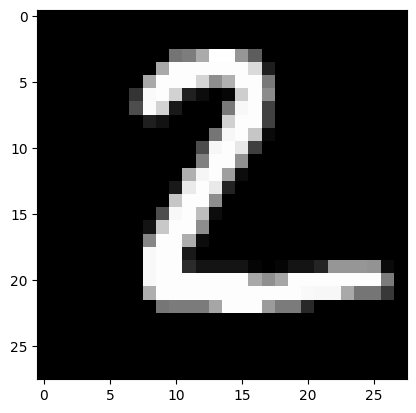

In [48]:
import matplotlib.pyplot as plt

x,y = valid_data[1]
image = transforms.ToPILImage()(x)
plt.imshow(image, cmap='gray')

pred = model_gpu(x.to(device))
pred.argmax(1).item()

In [56]:
import matplotlib.pyplot as plt

def muestra_imagen_prediccion(i):
    # obtenemos datos del dataset en posición i
    x,y = valid_data[i]
    # transformamos a imagen
    image = transforms.ToPILImage()(x)
    # mostramos la imagen en grande
    plt.imshow(image, cmap='gray')   
    plt.show() 
    # mostrar la etiqueta 
    print("Etiqueta numérica:   ", y)
    # hacemos inferencia
    pred = model_gpu(x.to(device))
    print("Predicción:          ", pred.argmax(1).item())

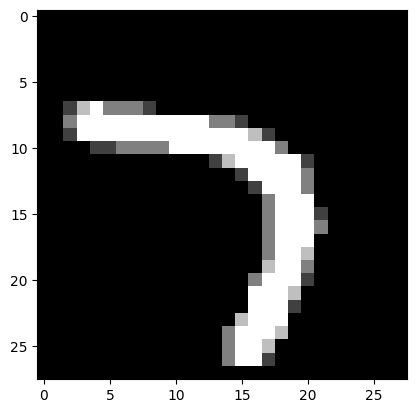

Etiqueta numérica:    7
Predicción:           7


In [57]:
x = 60 # prueba aquí otro número para ver otro ejemplo
muestra_imagen_prediccion(x)

Puedes usar el siguiente código para ver `k` ejemplos mal predichos.

Elemento:             18


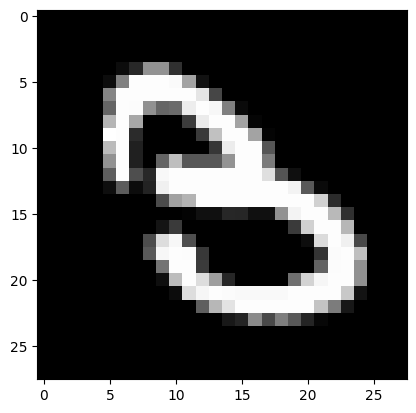

Etiqueta numérica:    3
Predicción:           5
----------------------
Elemento:             151


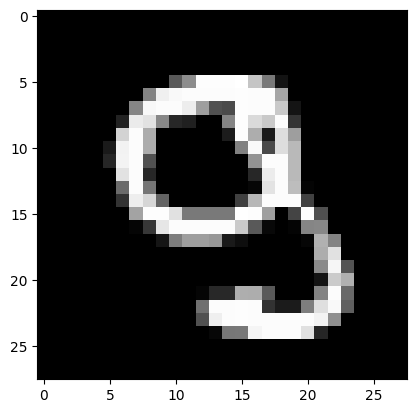

Etiqueta numérica:    9
Predicción:           5
----------------------
Elemento:             193


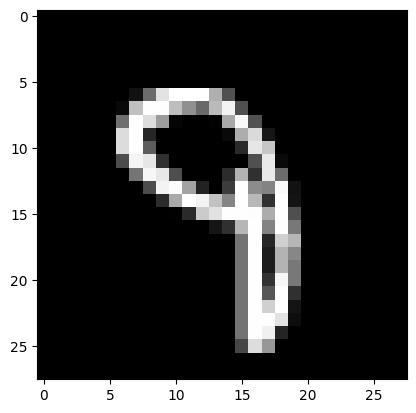

Etiqueta numérica:    9
Predicción:           8
----------------------
Elemento:             241


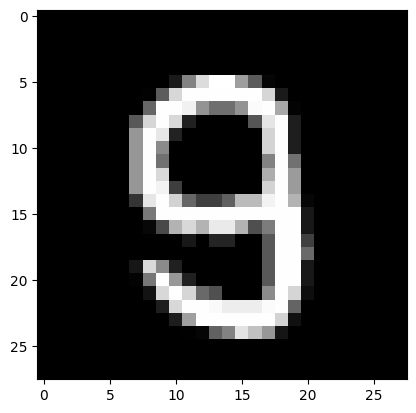

Etiqueta numérica:    9
Predicción:           8
----------------------


In [61]:
k=4
for i in range(0,len(valid_data)):
    x,y = valid_data[i]
    pred = model_gpu(x.to(device))
    if pred.argmax(1).item() != y:
        k=k-1
        if k<0:
            break;
        print ("Elemento:            ",i)
        muestra_imagen_prediccion(i)
        print("----------------------")

## 5. Ejercicio Opcional Propuesto

Juega con el entrenamiento del modelo para ver qué resultados obtienes y si consigues mejorar (o por el contrario se empeora el resultado): 
* cambia el método de [optimización](https://docs.pytorch.org/docs/stable/optim.html), 
* cambia el learning rate
* amplía el número de epochs, 
* añade o quita capas, 
* cambia las [funciones de activación](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity), 
* ¿Otra idea?